# Time of Flight Holdover Analysis
Here we will try to characterise the holdover performance of the LimeSDR. We have shown that when both the TX and RX have access to a PPS signal the time of flight can be accuratly calculated to $\pm$1 sample. During the ascent of the rocket however the on-board GPS will loose lock and we will have to rely on the Lime's VCTCXO to schedule the transmission of packets.

Lets make the following assumptions:
1. The RX knows exactly when the start of each second is, and is expecting the message to be sent then.
2. The TX believes its VCTCXO is running at $f_t$ = 30720000 and measures a second by counting samples. Each time the sample count, $n$, reaches an integer multiple of 30720000 the packet is sent.

Clearly the longer the TX runs, the worse the error gets. We have replaced the 8-bit DAC on the LimeSDR with a 12-bit DAC allowing for greater control of the output frequency of the VCTCXO. A controller was written to tune the VCTCXO to 30.72MHz based on the number of samples that occur between PPS edges. A moving average filter is used here and the controller can comfortably keep the output frequency averaged over 10 seconds within 0.25Hz of the desired.

Finally some gateware was written to implement a simple counter that produces a pulse every 30720000 samples. It is reset by the PPS signal from the GPSDO.

To begin with the test procedure was as follows:
1. Connect the PPS output of locked GPSDO 1 to CH1 of an oscilloscope.
2. Connect the PPS output of locked GPSDO 2 to the LimeSDR.
3. Connect the FPGA counter output to CH2 of the oscilloscope.
4. Run the tuning algorithm to allow the LimeSDR to trim the VCTCXO.
5. Record delay between PPS and counter output

Then the time delay between the PPS and the counter output was measured over a long duration, throughout which both GPSDOs had GPS lock. The average delay should be equal to the sum of the FPGA propogation delay and also the calibration error between the GPSDOs, which we estimated to be 9.79ns previosuly. This propogation delay arises from the fact that it takes a few clock cycles for the rising edge of the PPS to cause the counter output to rise. There is also variation due to the fact that the VCTCXO is constantly being retuning over the duration of the test.

Lets read in the data and plot the distribution.

<IPython.core.display.Javascript object>


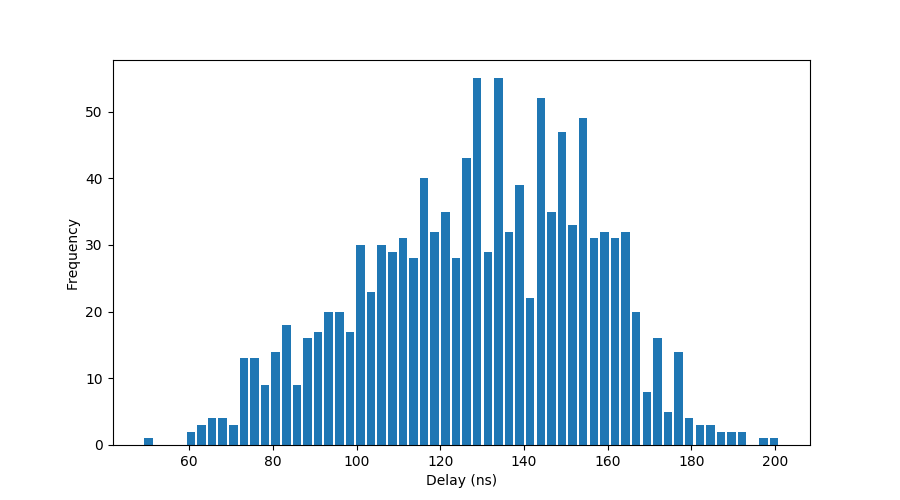

In [4]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV File
df = pd.read_csv('./holdover_lock.csv', names=['Time', 'Delay'])

# Generate new figure
fig = plt.figure(figsize=(9, 5))

# Plot Histogram
plt.hist(df['Delay']*1e9, bins=60, rwidth=0.8)
plt.ylabel('Frequency')
plt.xlabel('Delay (ns)')
plt.show()

In [3]:
# Stats
mx = df['Delay'].max()*1e9
mn = df['Delay'].min()*1e9
avg = df['Delay'].mean()*1e9
std_dev = df['Delay'].std()*1e9

data = [[mn, mx, avg, std_dev]]
df2 = pd.DataFrame(data, ['(ns)'], ['Min', 'Max', 'Avg.', 'Std'])
df2.round(2)

,Min,Max,Avg.,Std
(ns),49.0,201.0,129.0,27.02


Lets take the mean value to be the sum of all of the fixed offset errors in the system. We will subtract this value from our subsequent measurements. It seems as though here the transmission never occurs more than 80ns early or late relative to the PPS of the reciever. Using the trilateration MATLAB model this corresponds to an altitude error of $\pm$23m.

The next part of the test involved the following steps:
1. Remove the GPS antenna of GPSDO 2 which is being used by the LimeSDR. It will loose lock and stop generating a PPS. The LimeSDR will no longer tune the crystal and the DAC will remain at the last voltage. The FPGA counter will no longer be reset and will generate a pulse every 30720000 samples.
2. Measure the delay between the PPS output of GPSDO 1, which still has lock, and the FPGA counter output.

This is representative of whats going on in the transmitter because after losing lock it will just count samples to know when the start of the subsequent second is.

This test was carried out 3 times.

In [22]:
# Read CSV Files
unlock_hold_1 = pd.read_csv('./no_lock1.csv', names=['Time', 'Delay'])
unlock_hold_2 = pd.read_csv('./no_lock2.csv', names=['Time', 'Delay'])
unlock_hold_3 = pd.read_csv('./no_lock3.csv', names=['Time', 'Delay'])

# Adjust for Constant Offset
hold_over_1 = unlock_hold_1['Delay'] - avg*1e-9
hold_over_2 = unlock_hold_2['Delay'] - avg*1e-9
hold_over_3 = unlock_hold_3['Delay'] - avg*1e-9

<IPython.core.display.Javascript object>


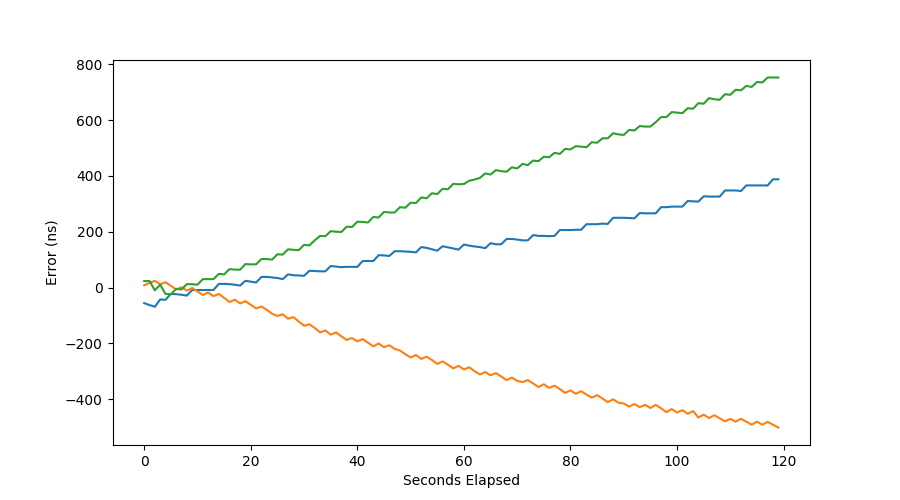

In [30]:
# Generate new figure
fig = plt.figure(figsize=(9, 5))

# Plot Error over 2 Mins
plt.plot(hold_over_1[0:120]*1e9)
plt.plot(hold_over_2[0:120]*1e9)
plt.plot(hold_over_3[0:120]*1e9)
plt.ylabel('Error (ns)')
plt.xlabel('Seconds Elapsed')
plt.show()

With this we can look at the altitude error after two minutes has elapsed. Using the MATLAB model we can work out the z error as before.

In [49]:
# Calculate Error
err1 = (abs(hold_over_1[0:120]).max())*1e9
err2 = -(abs(hold_over_2[0:120]).max())*1e9
err3 = (abs(hold_over_3[0:120]).max())*1e9

# Display Timing & Altitude Error
data2 = [[err1, err2, err3], [119,-153,230]]
df3 = pd.DataFrame(data2, ['Timing Error (ns)', 'Altitude Error (m)'], ['1', '2', '3'])
df3.round(2)

,1,2,3
Timing Error (ns),388.0,-502.0,753.0
Altitude Error (m),119.0,-153.0,230.0


## Conclusions
This looks okay, given that after 120 seconds the rocket should be well over 30km high which puts the worst case oberserved here at only a 0.7% error. In addition because the error is constant to all recievers, the X and Y position estimates are acually unaffected by the drift and retain there $\pm$30m accuracy throughout the full duration of the flight.

The drift here looks fairly linear suggesting that the VCTCXO is rather stable over this short duration but is not at exactly 30.72MHz, as expected. In the case of the green line, the true frequency of the LimeSDR works out to be 30 719 999.81 Hz, which is very close to the true frequency. 

I wonder if it is possible to perhaps do some kind of sensor fusion involving an pressure sensor which we know is reliable at low altitudes (~0 to 8km) to work out what the frequency difference is. 

Consider the following scheme:
1. Process our raw data and plot altitude over time
2. Overlay barometer readings for the first 5km say, which will be around 5-8 seconds of data.
3. Find the gradient of the above graph that minimises the mean squared error between the z estimate of the trilateration algorithm and the barometer reading.

Once this gradient is found we can then estimate the true frequency of the VCTCXO, and assuming it is constant over the flight we can then subtract the drift offset from all time of flight meaurements. This means that the later measurements, which correspond to altitudes where the pressure sensor is unreliable, should be more accurate.